# Overview 
In this assignment you will implement and test two supervised learning algorithms: linear regression (Problem 1) and logistic regression (Problem 2). 

For this assignment we will use the functionality of Pandas (https://pandas.pydata.org/), Matplotlib (https://matplotlib.org/), and Numpy (http://www.numpy.org/). You may also find Seaborn (https://seaborn.pydata.org/) useful for some data visualization.

If you are asked to **implement** a particular functionality, you should **not** use an existing implementation from the libraries above (or some other library that you may find). When in doubt, please ask. 

Before you start, make sure you have installed all those packages in your local Jupyter instance


## Read *all* cells carefully and answer all parts (both text and missing code)

You will complete all the code marked `TODO` and answer descriptive/derivation questions 



In [1]:
import random as rand

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split 
import sys

## Question 1: Linear Regression
We will implement linear regression using direct solution and gradient descent. 

We will first attempt to predict output using a single attribute/feature. Then we will perform linear regression using multiple attributes/features. 

### Getting data
In this assignment we will use the Boston housing dataset. 

The Boston housing data set was collected in the 1970s to study the relationship between house price and various factors such as the house size, crime rate, socio-economic status, etc.  Since the variables are easy to understand, the data set is ideal for learning basic concepts in machine learning.  The raw data and a complete description of the dataset can be found on the UCI website:

https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data

or 

http://www.ccs.neu.edu/home/vip/teach/MLcourse/data/housing_desc.txt

I have supplied a list `names` of the column headers.  You will have to set the options in the `read_csv` command to correctly delimit the data in the file and name the columns correctly.

In [2]:
names =[
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 
    'AGE',  'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'PRICE'
]

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data',
                 header=None,delim_whitespace=True,names=names,na_values='?')

### Basic Manipulations on the Data

What is the shape of the data?  How many attributes are there?  How many samples?
Print a statement of the form:

    num samples=xxx, num attributes=yy

In [3]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [4]:
numSamples, numAttributes = df.shape

print("num samples = " + str(numSamples) + ", num attributes = " + str(numAttributes))

num samples = 506, num attributes = 14


In order to properly test linear regression, we first need to find a set of correlated variables, so that we use one to predict the other. Consider the following scatterplots:

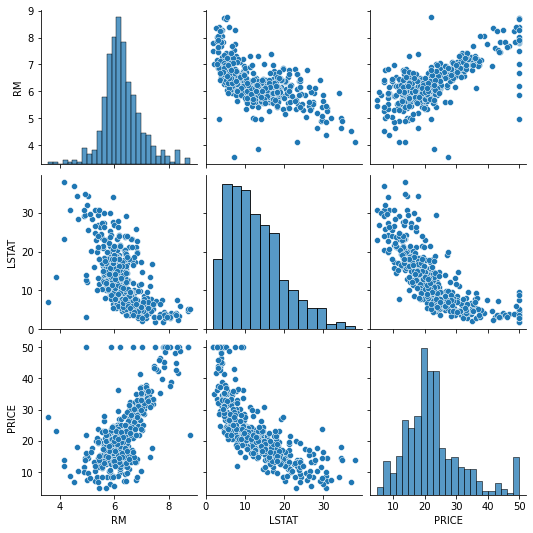

In [5]:
sb.pairplot(df[['RM','LSTAT','PRICE']])

Create a response vector `y` with the values in the column `PRICE`.  The vector `y` should be a 1D `numpy.array` structure.

In [6]:
df_np = df.to_numpy()
y = df_np[:, 13] # Column 13 (price)

Use the response vector `y` to find the mean house price in thousands and the fraction of homes that are above $40k. (You may realize this is very cheap.  Prices have gone up a lot since the 1970s!).   Create print statements of the form:

    The mean house price is xx.yy thousands of dollars.
    Only x.y percent are above $40k.

In [7]:
above40k = (y[y > 40])

print("The mean house price is " + str(format(y.mean(), ".2f")) + " thousands of dollars.")
print("Only " + str(format((above40k.size/y.size) * 100, ".1f")) + " percent are above $40k.")

The mean house price is 22.53 thousands of dollars.
Only 6.1 percent are above $40k.


### Visualizing the Data

Python's `matplotlib` has very good routines for plotting and visualizing data that closely follows the format of MATLAB programs.  You can load the `matplotlib` package with the following commands.

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

Similar to the `y` vector, create a predictor vector `x` containing the values in the `RM` column, which represents the average number of rooms in each region.

In [9]:
x = df_np[:, 5] #Column 5 (Avg rooms in each region)

Create a scatter plot of the price vs. the `RM` attribute.  Make sure your plot has grid lines and label the axes with reasonable labels so that someone else can understand the plot.

c:\Users\Administrator\Downloads\CODE\Python\Notebooks\notebookVenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Price (* $1k)')

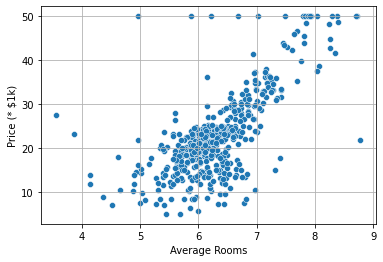

In [10]:
sb.scatterplot(x, y)
plt.grid()
plt.xlabel("Average Rooms")
plt.ylabel("Price (* $1k)")


The number of rooms and price seem to have a linear trend, so let us try to predict price using number of rooms first. 

### Question 1a. Derivation of a simple linear model for a single feature
Suppose we have $N$ pairs of training samples $(x_1,y_1),\ldots, (x_N,y_N)$, where $x_i \in \mathbb{R}$ and $y_i \in \mathbb{R}$. 

We want to perform a linear fit for this 1D data as 
$$y = wx+b,$$
where $w\in \mathbb{R}$ and $b\in \mathbb{R}$. 

In the class, we looked at the derivation of optimal value of $w$ when $b=0$. The squared loss function can be written as  $$L(w) = \sum_{i=1}^N(w x_i -y_i)^2,$$ and the optimal value of $w*$ that minimizes $L(w)$ can be written as $$w^* = (\sum_{i=1}^N x_i^2)^{-1}(\sum_{i=1}^N x_i y_i)$$. 


Now let us include $b$ in our model. Show that the optimal values of $w^*,b^*$ that minimize the loss function 
$$L(w,b) = \sum_{i=1}^N(wx_i + b -y_i)^2$$ 
can be written as 
$$w^* = (\sum_i (x_i - \bar{x})^2)^{-1}(\sum_i (x_i-\bar{x})(y_i-\bar{y}))$$
and $$b^* = \bar{y} - w^*\bar{x},$$
where $\bar{x} = \frac{1}{N}\sum_i x_i, \bar{y} = \frac{1}{N}\sum_i y_i$ are mean values of $x_i,y_i$, respectively. 



**TODO: Your derivation goes here.**




*   *Hint. Set the partial derivative of $L(w,b)$ with respect to $w$ and $b$ to zero.*
*   Type using latex commands and explain your steps

$L(w, b) = \sum_{i=1}^N(w^*x_i + b^* - y_i)^2 = \sum_{i=1}^N(x_i^Tw + b^* - y_i)^2$ ; Loss Function

$\frac{\partial L}{\partial b} = 2\sum_{i=1}^N (w^*x_i + b^* - y_i) = 0$ ; Set the partial derivative with respect to $b$ equal to 0

$\sum_{i=1}^N (w^*x_i + b^* - y_i) = 0$ ; Solve for $b^*$

$Nb^* + \sum_{i=1}^N (w^*x_i) - \sum_{i=1}^N(y_i) = 0$

$Nb^* = \sum_{i=1}^N(y_i) - \sum_{i=1}^N (w^*x_i)$

$b^* =\frac{1}{N}\sum_{i=1}^N y_i - w^* \frac{1}{N}\sum_{i=1}^N x_i$

$b^* = \bar{y} - w^*\bar{x}$ ; Optimal $b^*$



$\frac{\partial L}{\partial w} = 2\sum_{i=1}^N[(w^*x_i + b^* - y_i)(x_i)] = 0$ ; Set partial derivative with respect to $w$ equal to 0

$\sum_{i=1}^N(w^*x_i^2 + b^*x_i - y_ix_i) = 0$ ; Solve for $w^*$

$\sum_{i=1}^N(w^*x_i) + \sum_{i=1}^N(b^*) - \sum_{i=1}^N(y_i) = 0$ ; Divide both sides by $x_i$

$w^*\sum_{i=1}^Nx_i + Nb^* - \sum_{i=1}^Ny_i = 0$

$w^* = \frac{(\sum_{i=1}^Ny_i) - Nb^*}{\sum_{i=1}^Nx_i}$

$w^* = \frac{\sum_{i=1}^Ny_i - \sum_{i=1}^N y_i + w^* \sum_{i=1}^N x_i}{\sum_{i=1}^Nx_i}$ ; Subsitute expression for $b^*$ 

$w^* - \frac{w^* \sum_{i=1}^N x_i}{\sum_{i=1}^Nx_i}= \frac{\sum_{i=1}^Ny_i - \sum_{i=1}^N y_i}{\sum_{i=1}^Nx_i}$

$w^* = (\sum_i (x_i - \frac{1}{N}\sum_{i = 1}^N x_i)^2)^{-1}(\sum_{i = 1}^N (x_i - \frac{1}{N}\sum_{i = 1}^N x_i)(y_i - \frac{1}{N}\sum_{i = 1}^N y_i))$

$w^* = (\sum_i (x_i - \bar{x})^2)^{-1}(\sum_i (x_i-\bar{x})(y_i-\bar{y}))$


### Question 1b. Fitting a linear model using a single feature

Next we will write a function to perform a linear fit. Use the formulae above to compute the parameters $w,b$ in the linear model $y = wx + b$.

In [11]:
def fit_linear(x, y):
  """
  Given vectors of data points (x,y), performs a fit for the linear model:
     yhat = w*x + b, 
  The function returns w and b
  """
  sum1 = 0
  sum2 = 0
  N = x.size
    
  for i in range(N) :
    sum1 += (pow(x[i] - x.mean(), 2))
    sum2 += (x[i] - x.mean()) * (y[i] - y.mean())
    
  w = (1/sum1) * sum2
  b = y.mean() - (w * x.mean())

  return w, b

Using the function `fit_linear` above, print the values `w`, `b` for the linear model of price vs. number of rooms.

In [12]:
w, b = fit_linear(x, y)
print('w = {0:5.1f}, b = {1:5.1f}'.format(w,b))

w =   9.1, b = -34.7


Does the price increase or decrease with the number of rooms? 

* The price increases with the number of rooms because w > 1


Replot the scatter plot above, but now with the regression line.  You can create the regression line by creating points `xp` from say min(x) to max(x), computing the linear predicted values `yp` on those points and plotting `yp` vs. `xp` on top of the above plot.

c:\Users\Administrator\Downloads\CODE\Python\Notebooks\notebookVenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Administrator\Downloads\CODE\Python\Notebooks\notebookVenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Average Rooms', ylabel='Price (* $1k)'>

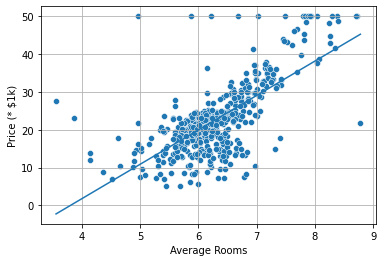

In [13]:
# Points on the regression line
sb.scatterplot(x, y)
plt.grid()
plt.xlabel("Average Rooms")
plt.ylabel("Price (* $1k)")

yp = np.empty(y.size)

for i in range(y.size): 
    yp[i] = (w * x[i]) + b

sb.lineplot(x, yp)

### Question 1c. Linear regression with multiple features/attributes
One possible way to try to improve the fit is to use multiple variables at the same time.

In this exercise, the target variable will be the `PRICE`.  We will use multiple attributes of the house to predict the price.  

The names of all the data attributes are given in variable `names`. 
* We can get the list of names of the columns from `df.columns.tolist()`.  
* Remove the last items from the list using indexing.

In [14]:
xnames = names[:-1]
print(names[:-1])

['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']


Let us use `CRIM`, `RM`, and `LSTAT` to predict `PRICE`. 

Get the data matrix `X` with three features (`CRIM`, `RM`, `LSTAT`) and target vector `y` from the dataframe `df`.  

Recall that to get the items from a dataframe, you can use syntax such as

    s = np.array(df['RM'])  
        
which gets the data in the column `RM` and puts it into an array `s`.  You can also get multiple columns with syntax like

    X12 = np.array(df['CRIM', 'ZN'])  


In [15]:
X = np.array(df[["CRIM", "RM", "LSTAT"]]) #CRIM, RM, STAT (2D Array)
y = df_np[:, 13] #PRICE (1D Array)

**Linear regression in scikit-learn**

To fit the linear model, we could create a regression object and then fit the training data with regression object.

```
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)
```

You can see the coefficients as
```
regr.intercept_
regr.coef_
```

We can predict output for any data as 

    y_pred = regr.predict(X)

**Instead of taking this approach, we will implement the regression function directly.**

**Linear regression by solving least-squares problem (direct solution)**

Suppose we have $N$ pairs of training samples $(x_1,y_1),\ldots, (x_N,y_N)$, where $\mathbf{x}_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$. 

We want to perform a linear fit over all the data features as 
$$y = \mathbf{\tilde w}^T\mathbf{x}+b,$$
where $\mathbf{\tilde w}\in \mathbb{R}^d$ and $b\in \mathbb{R}$. 

We saw in the class that we can write all the training data as a linear system 
$$ \begin{bmatrix} y_1 \\ \vdots \\ y_N \end{bmatrix} = \begin{bmatrix} - & \mathbf{x}_1^T & - \\ 
& \vdots & \\
- & \mathbf{x}_N^T& - \end{bmatrix} \mathbf{\tilde w} + b, $$
which can be written as 
$$ \begin{bmatrix} y_1 \\ \vdots \\ y_N \end{bmatrix} = \begin{bmatrix} 1 & \mathbf{x}_1^T \\ 
\vdots & \vdots \\
1 & \mathbf{x}_N^T\end{bmatrix} \begin{bmatrix} b \\ \mathbf{\tilde w} \end{bmatrix}.$$

Let us write this system of linear equations in a compact form as 
\begin{equation} 
\mathbf{y} = \mathbf{X}\mathbf{w}, 
\end{equation} 
where $\mathbf{X}$ is an $N \times d+1$ matrix whose first column is all ones and $\mathbf{w}$ is a vector of length $d+1$ whose first term is the constant and rest of them are the coefficients of the linear model. 

The least-squares problem for the system above can be written as 
$$\text{minimize}\; \frac{1}{2}\|\mathbf{y} - \mathbf{X}\mathbf{w}\|_2^2$$
for which the closed form solution can be written as 
$$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}.$$

**Append ones to the data matrix**

To compute the coefficients $\mathbf{\tilde w}$, we first append a vector of ones to the data matrix.  This can be performed with the `ones` command and `hstack`.  Note that after we do this, `X` will have one more column than before. 

In [16]:
ones = np.ones((numSamples, 1)) #(506, 1) array of 1's
X = np.hstack((ones, X)) #Append a 506 rows of 1's as the first column in X

np.set_printoptions(threshold = sys.maxsize)

**Split the Data into Training and Test**

Split the data into training and test.  Use 30% for test and 70% for training.  You can do the splitting manually or use the `sklearn` package `train_test_split`.   Store the training data in `Xtr,ytr` and test data in `Xts,yts`.


In [17]:
from sklearn.model_selection import train_test_split

(Xtr, Xts, ytr, yts) = train_test_split(X, y, test_size = 0.3)

Now let us compute the coefficients $\mathbf{w}$ using `Xtr,ytr` via the direct matrix inverse: $$\mathbf{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}.$$

You may use `np.linalg.inv` to compute the inverse. For a small problem like this, it makes no difference.  But, in general, using a matrix inverse like this is *much* slower computationally than using functions such as `lstsq` method or the `LinearRegression` class.  In real world, you will never solve a least squares problem like this. 

In [18]:
w = np.matmul(np.transpose(Xtr), Xtr)

w = np.linalg.pinv(w)

w = np.matmul(w, np.transpose(Xtr))

w = np.matmul(w, ytr)

print(w)

[-2.76642335 -0.09418046  5.246756   -0.57083398]


Compute the predicted values `yhat_tr` on the training data and print the average square loss value on the training data.

In [19]:
yhat_tr = np.matmul(Xtr, w)

avgSquareLoss = 0

for i in range(ytr.size):
    avgSquareLoss +=  pow((ytr[i] - yhat_tr[i]), 2)

avgSquareLoss = avgSquareLoss/ytr.size

print("Average square loss: " + str(avgSquareLoss))

Average square loss: 33.57120070103366


Create a scatter plot of the actual vs. predicted values of `y` on the training data.

c:\Users\Administrator\Downloads\CODE\Python\Notebooks\notebookVenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Actual')

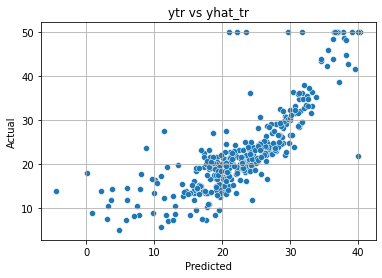

In [20]:
sb.scatterplot(yhat_tr, ytr)
plt.grid()
plt.title("ytr vs yhat_tr")
plt.xlabel("Predicted")
plt.ylabel("Actual")

Compute the predicted values `yhat_ts` on the test data and print the average square loss value on the test data.

In [21]:
yhat_ts = np.matmul(Xts, w)

for i in range(yts.size):
    avgSquareLoss +=  pow((yts[i] - yhat_ts[i]), 2)

avgSquareLoss = avgSquareLoss/yts.size

print("Average square loss: " + str(avgSquareLoss))

Average square loss: 21.638081296706698


Create a scatter plot of the actual vs. predicted values of `y` on the test data.

c:\Users\Administrator\Downloads\CODE\Python\Notebooks\notebookVenv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Actual')

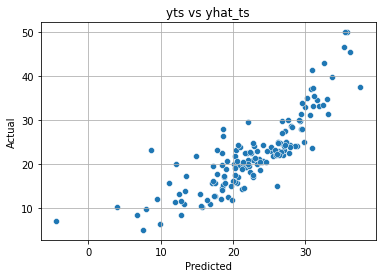

In [22]:
sb.scatterplot(yhat_ts, yts)
plt.grid()
plt.title("yts vs yhat_ts")
plt.xlabel("Predicted")
plt.ylabel("Actual")

### Question 1d: Gradient descent for linear regression
Finally, we will implement the gradient descent version of linear regression.

In particular, the function implemented should follow the following format:
```python
def linear_regression_gd(X,y,learning_rate = 0.00001,max_iter=10000,tol=pow(10,-5)):
```
Where `X` is the same data matrix used above (with ones column appended), `y` is the variable to be predicted, `learning_rate` is the learning rate used ($\alpha$ in the slides), `max_iter` defines the maximum number of iterations that gradient descent is allowed to run, and `tol` is defining the tolerance for convergence (which we'll discuss next).

The return values for the above function should be (at the least) 1) `w` which are the regression parameters, 2) `all_cost` which is an array where each position contains the value of the objective function $L(\mathbf{w})$ for a given iteration, 3) `iters` which counts how many iterations did the algorithm need in order to converge to a solution.

Gradient descent is an iterative algorithm; it keeps updating the variables until a convergence criterion is met. In our case, our convergence criterion is whichever of the following two criteria happens first:

- The maximum number of iterations is met
- The relative improvement in the cost is not greater than the tolerance we have specified. For this criterion, you may use the following snippet into your code:
```python
np.absolute(all_cost[it] - all_cost[it-1])/all_cost[it-1] <= tol
```

Gradient can be computed as $$\nabla_\mathbf{w}L = \mathbf{X}^T(\mathbf{X}\mathbf{w} - \mathbf{y}).$$

Estimate will be updated as $\mathbf{w} \gets \mathbf{w} - \alpha \nabla_\mathbf{w}L$ at every iteration. 

**Note that the $\mathbf{w}$ in this derivation includes the constant term and $\mathbf{X}$ is a matrix that has ones column appended to it.**

In [23]:
# Implement gradient descent for linear regression 
highestIteration = 0

def compute_cost(X, w, y):
    # your code for the loss function goes here 
    L = np.ndarray.flatten(np.matmul(X, w)) #Xw
    L = np.subtract(L, y) #Xw - y
    L = np.matmul(np.transpose(X), L) #X transpose * (Xw - y)
    return L # Gradient of L

def linear_regression_gd(X, y, learning_rate = 0.00001, max_iter = 10000, tol = pow(10, -5),
                          iters = 1, w = np.ndarray.flatten(np.array([np.random.randn(4, 1)])), all_cost = np.ones(10000)):
  # your code goes here 

  global highestIteration
  if(iters == 1) :
    highestIteration = 0 # Reset highestIteration to 0 on first run of function

  numSamples = int(X.size/4)

  if(iters > max_iter) : # Convergence criteria 1
    return w, all_cost, iters # Return and exit
  else : 
    L = compute_cost(X, w, y) # L is gradient
    w = w - (learning_rate * L) # Update w

    # Calculate cost using Loss Function (L(w), b is included in w)
    cost = 0
    for i in range(numSamples) : #(wxi - yi)^2 for i = 0 to numSamples
      cost += pow((np.matmul(w, X[i]) - y[i]), 2)
    all_cost[iters] = cost # Update all_cost for this iteration

    # Convergence criteria 2
    if(np.absolute(all_cost[iters] - all_cost[iters - 1])/all_cost[iters - 1] <= tol) : # Cost improvement <= tol
      return w, all_cost, iters # Return and exit
    else : # No convergence criterion met
      iters += 1 # Increment iteration
      if(iters > highestIteration) :
        highestIteration = iters
      linear_regression_gd(X, y, iters = iters, w = w, all_cost = all_cost) # Call function until one of the convergence criterion are met

  iters = highestIteration
  return w, all_cost, iters #Returns 1st w and iters rather than last**

w, all_cost, iters = linear_regression_gd(X, y)

### Question 1e: Convergence plots
After implementing gradient descent for linear regression, we would like to test that indeed our algorithm converges to a solution. In order see this, we are going to look at the value of the objective/loss function $L(\mathbf{w})$ as a function of the number of iterations, and ideally, what we would like to see is $L(\mathbf{w})$ drops as we run more iterations, and eventually it stabilizes. 

The learning rate plays a big role in how fast our algorithm converges: a larger learning rate means that the algorithm is making faster strides to the solution, whereas a smaller learning rate implies slower steps. In this question we are going to test two different values for the learning rate:
- 0.00001
- 0.000001

while keeping the default values for the max number of iterations and the tolerance.


- Plot the two convergence plots (cost vs. iterations) [5]

- What do you observe? [5]

<b>Important</b>: In reality, when we are running gradient descent, we should be checking convergence based on the <i>validation</i> error (i.e., we would have to split our training set into e.g., 70/30 training'/validation subsets, use the new training set to calculate the gradient descent updates and evaluate the error both on the training set and the validation set, and as soon as the validation loss stops improving, we stop training. <b>In order to keep things simple, in this assignment we are only looking at the training loss</b>, but as long as you have a function 
```python
def compute_cost(X,w,y):
```
that calculates the loss for a given X, y, and set of parameters you have, you can always compute it on the validation portion of X and y (that are <b>not</b> used for the updates).  

152
153


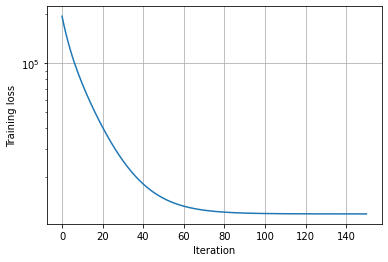

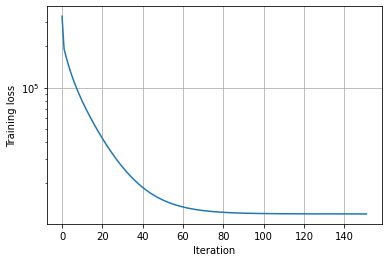

In [24]:
# test gradient descent with step size 0.00001
# test gradient descent with step size 0.000001

(w, all_cost, iters) = linear_regression_gd(Xtr, ytr, learning_rate = 0.00001, max_iter = 1000, tol = pow(10,-6))  
plt.figure(0)
plt.semilogy(all_cost[1:iters])    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')  
print(iters)

# complete the rest
(w, all_cost, iters) = linear_regression_gd(Xtr, ytr, learning_rate = 0.000001, max_iter = 1000, tol = pow(10,-6))  
plt.figure(1)
plt.semilogy(all_cost[1:iters])    
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Training loss')  
print(iters)

Observations: 

1. The training loss strictly decreases after each iteration
2. The graph with the larger learning rate (0.00001) converges slower than the graph with the smaller learning rate (0.000001). We can confirm this by the printing the number of iterations (iters) it takes to converge for each

### Question 2. Logistic regression
In this question, we will plot the logistic function and perform logistic regression. We will use the breast cancer data set.  This data set is described here:

https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin

Each sample is a collection of features that were manually recorded by a physician upon inspecting a sample of cells from fine needle aspiration.  The goal is to detect if the cells are benign or malignant.  

We could use the `sklearn` built-in `LogisticRegression` class to find the weights for the logistic regression problem.  The `fit` routine in that class has an *optimizer* to select the weights to best match the data.  To understand how that optimizer works, in this problem, we will build a very simple gradient descent optimizer from scratch.  

### Loading and visualizing the Breast Cancer Data

We load the data from the UCI site and remove the missing values.

In [25]:
names = ['id','thick','size_unif','shape_unif','marg','cell_size','bare',
         'chrom','normal','mit','class']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/' +
                 'breast-cancer-wisconsin/breast-cancer-wisconsin.data',
                names=names, na_values='?', header=None)
df = df.dropna() # Remove missing values
df.head(6) #683 rows, 13 columns

,id,thick,size_unif,shape_unif,marg,cell_size,bare,chrom,normal,mit,class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2
5,1017122,8,10,10,8,7,10.0,9,7,1,4


After loading the data, we can create a scatter plot of the data labeling the class values with different colors.  We will pick two of the features.  

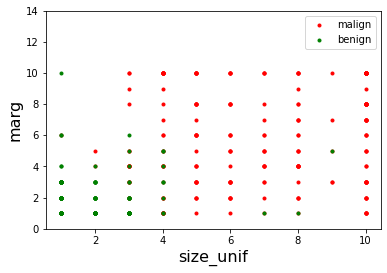

In [27]:
# Get the response.  Convert to a zero-one indicator 
yraw = np.array(df['class'])
BEN_VAL = 2   # value in the 'class' label for benign samples
MAL_VAL = 4   # value in the 'class' label for malignant samples
y = (yraw == MAL_VAL).astype(int)
Iben = (y == 0)
Imal = (y == 1)

# Get two predictors
xnames =['size_unif','marg'] 
X = np.array(df[xnames]) # 2 columns for size_unif and marg

# Create the scatter plot
plt.plot(X[Imal, 0], X[Imal, 1], 'r.')
plt.plot(X[Iben, 0], X[Iben, 1], 'g.')
plt.xlabel(xnames[0], fontsize = 16)
plt.ylabel(xnames[1], fontsize = 16)
plt.ylim(0, 14)
plt.legend(['malign', 'benign'], loc = 'upper right')

The above plot is not informative, since many of the points are on top of one another.  Thus, we cannot see the relative frequency of points.  

### Logistic function

We will build a binary classifier using *logistic regression*.  In logistic regression, we do not just output an estimate of the class label.  Instead, we ouput a *probability*, an estimate of how likely the sample is one class or the other.  That is our output is a number from 0 to 1 representing the likelihood:
$$
    P(y = 1|x)
$$
which is our estimate of the probability that the sample is one class (in this case, a malignant sample) based on the features in `x`.  This is sometimes called a *soft classifier*.  

In logistic regression, we assume that likelihood is of the form
$$
    P(y=1|x) = \sigma(z),  \quad z = w(1)x(1) + \cdots + w(d)x(d) + b = \mathbf{w}^T\mathbf{x}+b,  
$$
where $w(1),\ldots,w(d),b$ are the classifier weights and $\sigma(z)$ is the so-called *logistic* function:
$$
    \sigma(z) = \frac{1}{1+e^{-z}}.
$$

To understand the logistic function, suppose $x$ is a scalar and samples $y$ are drawn with $P(y=1|x) = f(w x+b)$ for some $w$ and $b$.  We plot these samples for different $w,b$.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_13340\4188138851.py:21: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')


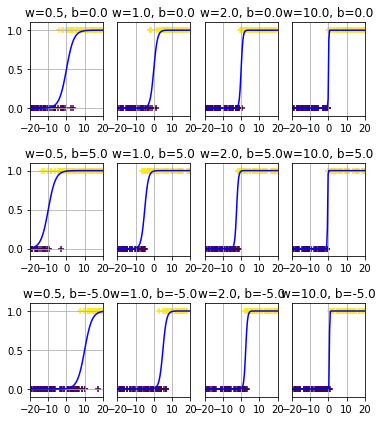

In [28]:
N = 100
xm = 20
ws = np.array([0.5,1,2,10])
bs = np.array([0, 5, -5])
wplot = ws.size
bplot = bs.size
iplot = 0
for b in bs: 
  for w in ws:
    iplot += 1
    x  = np.random.uniform(-xm,xm,N)
  
    py = 1/(1+np.exp(-w*x-b))
 
    yp = np.array(np.random.rand(N) < py) # hard label for random points
    xp = np.linspace(-xm,xm,100) 
    pyp = 1/(1+np.exp(-w*xp-b)) # soft label (probability) for the points

    plt.subplot(bplot,wplot,iplot)

    plt.scatter(x,yp,c=yp,edgecolors='none',marker='+')
    plt.plot(xp,pyp,'b-')
    plt.axis([-xm,xm,-0.1,1.1])
    plt.grid() 
    if ((iplot%4)!=1):
        plt.yticks([])
    plt.xticks([-20,-10,0,10,20])
    plt.title('w={0:.1f}, b={1:.1f}'.format(w,b))

    plt.subplots_adjust(top=1.5, bottom=0.2, hspace=0.5, wspace=0.2)

We see that $\sigma(wx+b)$ represents the probability that $y=1$.  The function $\sigma(wx) > 0.5$ for $x>0$ meaning the samples are more likely to be $y=1$.  Similarly, for $x<0$, the samples are more likely to be $y=0$.  The scaling $w$ determines how fast that transition is and $b$ influences the transition point.  

### Fitting the Logistic Model on Two  Variables

We will fit the logistic model on the two variables `size_unif` and `marg` that we were looking at earlier.

In [29]:
# load data 
xnames =['size_unif','marg'] 
X = np.array(df[xnames])
print(X.shape)

(683, 2)


In [30]:
#Append ones to X
ones = np.ones((numSamples, 1)) #(506, 1) array of 1's
X = np.hstack((ones, X)) #Append a 506 rows of 1's as the first column in X

Next we split the data into training and test

In [31]:
# Split into training and test
from sklearn.model_selection import train_test_split
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size = 0.30)

**Logistic regression in scikit-learn**

The actual fitting is easy with the `sklearn` package.  The parameter `C` 
states the level of inverse regularization strength with higher values meaning less regularization. Right now, we will select a high value to minimally regularize the estimate.

We can also measure the accuracy on the test data. You should get an accuracy around 90%. 

In [32]:
from sklearn import datasets, linear_model, preprocessing
reg = linear_model.LogisticRegression(C = 1e5)
reg.fit(Xtr, ytr)

print(reg.coef_)
print(reg.intercept_)

yhat = reg.predict(Xts)
acc = np.mean(yhat == yts)
print("Accuracy on test data = %f" % acc)

[[-2.61192246  1.24043121  0.34458435]]
[-2.61192581]
Accuracy on test data = 0.960976


**Instead of taking this approach, we will implement the regression function using gradient descent.**

### Question 2a. Gradient descent for logistic regression
In the class we saw that the weight vector can be found by minimizing the negative log likelihood over $N$ training samples.  The negative log likelihood is called the *loss* function.  For the logistic regression problem, the loss function simplifies to

$$L(\mathbf{w}) = - \sum_{i=1}^N y_i \log \sigma(\mathbf{w}^T\mathbf{x}_i+b) + (1-y_i)\log [1-\sigma(\mathbf{w}^T\mathbf{x}_i+b)].$$

Gradient can be computed as $$\nabla_\mathbf{w}L = \sum_{i=1}^N(\sigma(\mathbf{w}^T\mathbf{x}_i)-y_i)\mathbf{x}_i ,~~~ \nabla_b L = \sum_{i=1}^N(\sigma(\mathbf{w}^T\mathbf{x}_i)-y_i).$$


We can update $\mathbf{w},b$ at every iteration as  
$$ \mathbf{w} \gets \mathbf{w} - \alpha \nabla_\mathbf{w}L, \\ b \gets b - \alpha \nabla_b L.$$ 

**Note that we could also append the constant term in $\mathbf{w}$ and append 1 to every $\mathbf{x}_i$ accordingly, but we kept them separate in the expressions above.**

 

**Gradient descent function implementation** 

We will use this loss function and gradient to implement a gradient descent-based method for logistic regression.

Recall that training a logistic function means finding a weight vector `w` for the classification rule:

    P(y=1|x,w) = 1/(1+\exp(-z)), z = w[0]+w[1]*x[1] + ... + w[d]x[d]
    
The function implemented should follow the following format:
```python
def logistic_regression_gd(X,y,learning_rate = 0.001,max_iter=1000,tol=pow(10,-5)):
```
Where `X` is the training data feature(s), `y` is the variable to be predicted, `learning_rate` is the learning rate used ($\alpha$ in the slides), `max_iter` defines the maximum number of iterations that gradient descent is allowed to run, and `tol` is defining the tolerance for convergence (which we'll discuss next).

The return values for the above function should be (at the least) 1) `w` which are the regression parameters, 2) `all_cost` which is an array where each position contains the value of the objective function $L(\mathbf{w})$ for a given iteration, 3) `iters` which counts how many iterations did the algorithm need in order to converge to a solution.

Gradient descent is an iterative algorithm; it keeps updating the variables until a convergence criterion is met. In our case, our convergence criterion is whichever of the following two criteria happens first:

- The maximum number of iterations is met
- The relative improvement in the cost is not greater than the tolerance we have specified. For this criterion, you may use the following snippet into your code:
```python
np.absolute(all_cost[it] - all_cost[it-1])/all_cost[it-1] <= tol
```

In [33]:
def compute_cost(X, w, y, numSamples):
  L = np.ndarray(3)

  for i in range(numSamples) :
    z = np.matmul(w, X[i])
    sigma = 1/(1 + np.exp(-z))
    L += (sigma - y[i]) * X[i]
    
  return L # Gradient of L, 3x1 matrix

def logistic_regression_gd(X, y, learning_rate = 0.00001, max_iter=750, tol=pow(10,-5),
                           iters = 1, w = np.ndarray.flatten(np.array([np.random.randn(3, 1)])), all_cost = np.ones(1000)):
  global highestIteration

  if(iters == 1) :
    highestIteration = 0 # Reset highestIteration to 0 on first run of function

  numSamples = int(X.size/3)

  if(iters > max_iter) : # Convergence criteria 1
    return w, all_cost, iters # Return and exit
  else : 
    L = compute_cost(X, w, y, numSamples) # L is gradient
    w = w - (learning_rate * L) # Update w

    # Calculate cost using Loss Function (L(w), b is included in w)
    cost = 0
    for i in range(numSamples) : #-[yilog(sigma(z)) +(1 - yi)log(1 - sigma(z))] for i = 0 to numSamples
      z = np.matmul(w, X[i])
      sigma = (1/(1 + np.exp(-z)))
      cost -= (y[i] * np.log(sigma)) + ((1 - y[i]) * (np.log(1 - sigma)))

    all_cost[iters] = cost # Update all_cost for this iteration

    # Convergence criteria 2
    if(np.absolute(all_cost[iters] - all_cost[iters - 1])/all_cost[iters - 1] <= tol) : # Cost improvement <= tol
      return w, all_cost, iters # Return and exit
    else : # No convergence criterion met
      iters += 1 # Increment iteration
      
      if(iters > highestIteration) :
        highestIteration = iters
      
      logistic_regression_gd(X, y, iters = iters, w = w, all_cost = all_cost) # Call function until one of the convergence criterion are met

  iters = highestIteration
  return w, all_cost, iters #Returns 1st w and iters rather than last**

w, all_cost, iters = logistic_regression_gd(X, y)

### Question 2b: Convergence plots and test accuracy

After implementing gradient descent for logistic regression, we would like to test that indeed our algorithm converges to a solution. In order see this, we are going to look at the value of the objective/loss function $L(\mathbf{w})$ as a function of the number of iterations, and ideally, what we would like to see is $L(\mathbf{w})$ drops as we run more iterations, and eventually it stabilizes. 

The learning rate plays a big role in how fast our algorithm converges: a larger learning rate means that the algorithm is making faster strides to the solution, whereas a smaller learning rate implies slower steps. In this question we are going to test two different values for the learning rate:
- 0.001
- 0.00001

while keeping the default values for the max number of iterations and the tolerance.


- Plot the two convergence plots (cost vs. iterations)
- Calculate the accuracy of classifier on the test data `Xts` 
- What do you observe? 


**Calculate accuracy of your classifier on test data**

To calculate the accuracy of our classifier on the test data, we can create a predict method. 

Implement a function `predict(X,w)` that provides you label 1 if $\mathbf{w}^T\mathbf{x} + b > 0$ and 0 otherwise.  

In [34]:
# Predict on test samples and measure accuracy
def predict(X, w):
  wx = 0
  numSamples = int(X.size/3)

  for i in range(numSamples) :
    wx += np.matmul(w, X[i])

  if(wx > 0) :
    yhat = 1
  else :
    yhat = 0
  return yhat

Step Size = 0.001
Cost at iteration 50: 235.3975995268136
Cost at iteration 100: 223.4594798370629
Cost at iteration 500: 193.45619448315787
Cost at iteration 750: 180.43466191468204
Step Size = 0.00001
Cost at iteration 50: 239.2214235524863
Cost at iteration 100: 232.93566790775265
Cost at iteration 500: 200.16691797655923
Cost at iteration 750: 185.7998899062734
Test accuracy = 0.634146


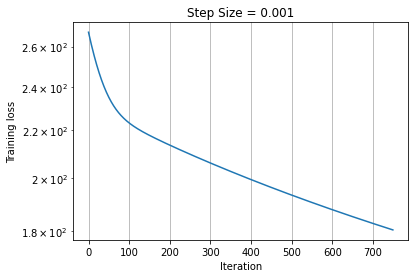

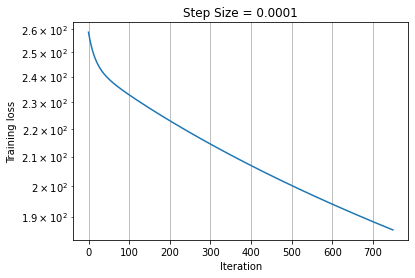

In [35]:
# test gradient descent with step size 0.001
# test gradient descent with step size 0.00001
 
(w, all_cost, iters) = logistic_regression_gd(Xtr, ytr, learning_rate = 0.001, max_iter = 1000, tol=pow(10,-6))  
plt.figure(0)
plt.semilogy(all_cost[1:iters])    
print("Step Size = 0.001")
print("Cost at iteration 50: " + str(all_cost[50]))
print("Cost at iteration 100: " + str(all_cost[100]))
print("Cost at iteration 500: " + str(all_cost[500]))
print("Cost at iteration 750: " + str(all_cost[750]))
plt.grid()
plt.title("Step Size = 0.001")
plt.xlabel('Iteration')
plt.ylabel('Training loss') 

# complete the rest
(w, all_cost, iters) = logistic_regression_gd(Xtr, ytr, learning_rate = 0.00001, max_iter = 1000, tol = pow(10,-6))  
plt.figure(1)
plt.semilogy(all_cost[1:iters])
print("Step Size = 0.00001") 
print("Cost at iteration 50: " + str(all_cost[50]))
print("Cost at iteration 100: " + str(all_cost[100]))
print("Cost at iteration 500: " + str(all_cost[500]))
print("Cost at iteration 750: " + str(all_cost[750]))
plt.grid()
plt.title("Step Size = 0.0001")
plt.xlabel('Iteration')
plt.ylabel('Training loss')  

yhat = predict(Xts, w)
acc = np.mean(yhat == yts)
print("Test accuracy = %f" % acc)

Observations: 

1. The loss value for both graphs strictly decreases per iteration just like the linear regression graphs
2. The graph with the larger step size (0.001) converges faster than the graph with the smaller step size (0.00001). We can confirm this by taking note of the costs at each iteration. cost[50] for step size 0.00001 is actually better than cost[50] for step size 0.001, but afterwards, the cost values for step size 0.00001 are better.
3. The graphs don't converge until the maximum iterations are met. This means that the losses are still changing at a rate > tol (pow(10, -6)). Maximum iterations was set to 750 because at 1000, the function would crash. 